In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

8135
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
path_save_ = "./jupyter-notebooks/NL/results/"
path_qucf_ = "../QuCF/simulations/LCHS-KvN/"
for _ in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# CL   - classical (simulations)
# QuCF - framework used for quantum computations
# LCHS - Linear Combination of Hamiltonian Simulations
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - x* (x**2 - 0.25)
t_max, x_max = 4.0, 1
# ----------------------------------------

nx_ = 7 
nk_    = 5
k_max_ = 10
nt_ = 11

ratio_qucf_dt_ = 10  # ratio of CL and QuCF time steps
Nt_qucf_ = 100      # number of time steps in QuCF simulations

print("nx: {:d}".format(nx_))
print("nt: {:d}".format(nt_))
print("nk: {:d}".format(nk_))
print()
print("// Number of time steps in the QuCF simulation")
print("Nt {:d}".format(Nt_qucf_))

# --- Time grid ---
Nt = 1<<nt_
t = np.linspace(0,t_max,Nt)

dt = np.diff(t)[0]             # time step for CL simulations
t_step_qc_ = dt/ratio_qucf_dt_ # time step used in LCHS for trotterization;
id_t_compare_ = Nt_qucf_ // ratio_qucf_dt_ # CL time point where CL sim. should be compared with QuCF;

# --- Linear x- grid ---
Nx_ = 1 << nx_
x_lin_ = np.linspace(-x_max, x_max, Nx_)  
dx_    = np.diff(x_lin_)[0]

# --- k-grid ---
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

# --- Hermitian and anti-Hermitian parts of i*H ---
print("\n--- UPWINDING DIFFERENCE SCHEME ---")
H_UW_, Aa_, Ah_, _, _ = kvn.construct_UW_matrix_1D(x_lin_, F_, flag_asin = False)

# --- LCHS matrices ---
Ba_, Bm_, Bk_ = kvn.compute_norm_matrices_LCHS(
    Aa_, Ah_, k_max_, dk_, 
    t_step = t_step_qc_,
    factor_global_a    = 4.555319024641,
    factor_global_kmax = 4.557453940854,
    factor_global_k    = 4.557453940854,
)

nx: 7
nt: 11
nk: 5

// Number of time steps in the QuCF simulation
Nt 100

--- UPWINDING DIFFERENCE SCHEME ---
Matrix Ba:	 nonsparsity, coefnorm: 2, 6.359e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 1.651e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 1.065e+02

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

--- Time steps ---
dt_a:    2.830214e-02
dt_kmax: 1.470376e+00
dt_k:    9.486300e-02


In [4]:
# --------------------------------------------------
# --- Python simulations ---
# --------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)
mix.reload_module(kvn)

def solve_standart(x_center_ref):
    oo = RK45(
        lambda t,x: F_(x), 
        t[0], 
        [x_center_ref], t[-1], first_step=dt, max_step=dt
    )
    
    sol_ref = np.zeros(Nt, dtype=float)
    sol_ref[0] = x_center_ref
    Nt_act = 1
    
    oo.step()
    oo.t
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        if Nt_act - 1 == Nt:
            print(oo.t)
        sol_ref[Nt_act-1] = float(oo.y[0])
    return sol_ref
# --------------------------------------------------------------------------

# --- Rereference simulations ---
x_centers_ = [-0.95 + 0.05 * ii for ii in range(40)]
sol_refs = []
for i_center in range(len(x_centers_)):
    x_center = x_centers_[i_center]
    sol_one = solve_standart(x_center)
    sol_refs.append(sol_one)

# --- KvN simulations ---
psi_init_ = np.ones(Nx_) * 2**(-nx_/2.)
psi_ref_   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx_, psi_init_, H_UW_)

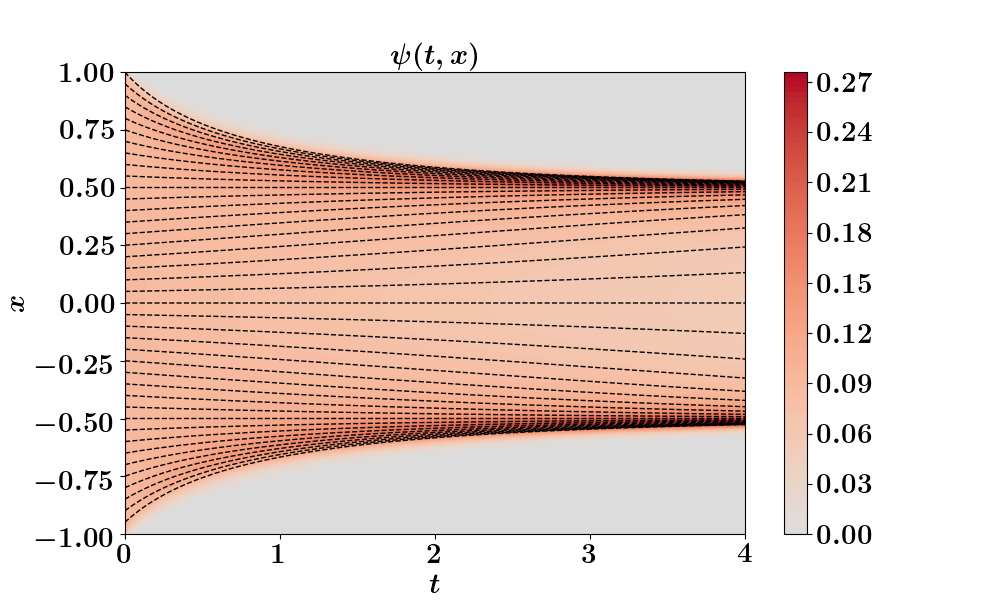

In [5]:
# --------------------------------------------------
# --- Compare python simulations ---
# --------------------------------------------------
from scipy.integrate import RK45
from matplotlib import colors as plt_colors
mix.reload_module(mix)
mix.reload_module(kvn)

cmap_two_signs_= 'coolwarm'
divnorm=plt_colors.TwoSlopeNorm(vcenter=0.)

fontsize = 20
linewidth = 4

XX, YY = np.meshgrid(t, x_lin_)
fig_tx = plt.figure(figsize=(10, 6))
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, np.transpose(psi_ref_.real), levels=100, cmap='coolwarm', norm=divnorm)
cb = fig_tx.colorbar(cs, ax = ax)
cb.ax.ticklabel_format(style="scientific")
cb.ax.tick_params(labelsize=fontsize) 
coef_lw = 0.25
ax.plot(t, sol_refs[0], color='black', linewidth = linewidth * coef_lw, linestyle='--', label="ref")
for i_ref in range(1,len(sol_refs)):
    ax.plot(t, sol_refs[i_ref], color='black', linewidth = linewidth * coef_lw, linestyle='--')
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_ylabel('$x$', fontsize = fontsize)
ax.set_title('$\psi(t,x)$', fontsize = fontsize)
ax.set_xlim(0, t_max)
ax.set_ylim(-x_max, x_max)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
del fontsize, fig_tx

In [ ]:
# ---------------------------------------------------------------------------------------
# --- Compare with the QuCF computations ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
mix.reload_module(mse)

# ------------------------------------------------------------------------------
def read_data():
    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = "kvn"
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    
    print("success prob: {:0.3e}".format(
        np.sum(np.abs(qc_state_t)**2)
    ))

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.dd_["weights"]["par"]
    Nk_c = 1 << nk_c
    k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    dk_c = np.diff(k_grid)[0]
    print("nk: {:d}".format(nk_c))

    # renormalization:
    Hadamart_norm_factor = 2**(nk_c) 
    coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    qc_state_t *= coef_norm * (dk_c / np.pi)
    return qc_state_t

# -------------------------------------------------
def plot_QuCF_vs_Py(psi_qc):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x_lin_, psi_ref_.real[id_t_compare_,:], "-b", linewidth = 2, label="CL: Re")
    ax.plot(x_lin_, psi_ref_.imag[id_t_compare_,:], "-r", linewidth = 2, label="CL: Im")
    
    ax.plot(x_lin_, coef_sign_ * psi_qc.real, "-", color='green', linewidth = 2, label = "QC: Re")
    ax.plot(x_lin_, coef_sign_ * psi_qc.imag, "-", color='black', linewidth = 2, label = "QC: Im")

    plt.xlabel('$x$')
    plt.ylabel("$\psi(x,t1)$")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# ------------------------------------------------------------------------------
coef_sign_ = -1

# --- Reading QuCF simulations ---
print("--------------------------------------------------")
print("--- Reading QuCF results---")
print("--------------------------------------------------")
psi_qc = read_data() 

# --- Comparison: QuCF-LCHS versus Python-LCHS ---
plot_QuCF_vs_Py(psi_qc)
print("t1 = {:0.3e}".format(t[id_t_compare_]))